# Guided Exposure Fusion

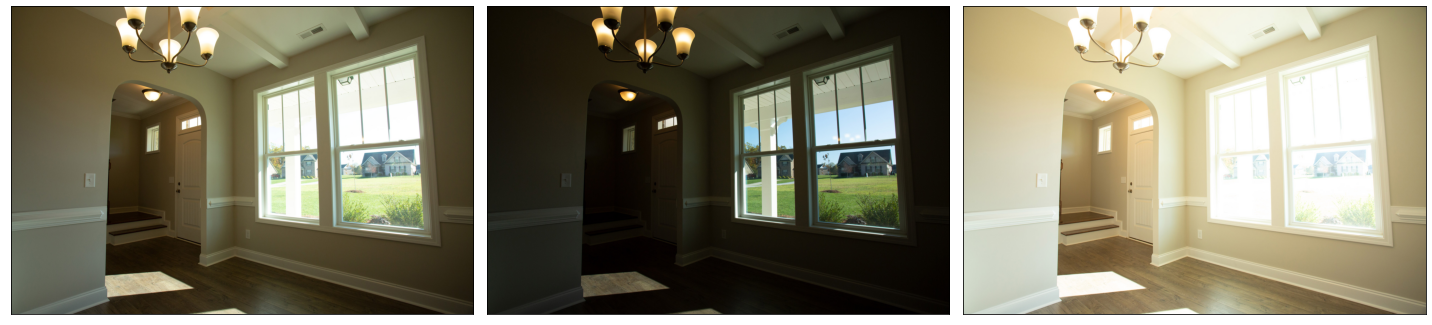

In [1]:
from matplotlib import pyplot as plt
from numpy import asarray
from PIL import Image
from torchvision.transforms import Compose, Normalize, Resize, ToPILImage, ToTensor

# Load
image_a = Image.open("../media/approximations/1.jpg")
image_b = Image.open("../media/approximations/2.jpg")
image_c = Image.open("../media/approximations/3.jpg")

# Plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(image_a)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(image_b)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(image_c)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [2]:
from torchvision.transforms import Compose, Normalize, Resize, ToPILImage, ToTensor

# Conversion
to_tensor = Compose([
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
to_image = Compose([
    Normalize(mean=[-1., -1., -1.], std=[2., 2., 2.]),
    ToPILImage()
])
to_map = Compose([
    Normalize(mean=[1.], std=[1.]),
    ToPILImage()
])
to_greyscale = Compose([
    Normalize(mean=[-1.], std=[2.]),
    ToPILImage()
])

# Convert to tensor
image_ten_a = to_tensor(image_a).unsqueeze(dim=0)
image_ten_b = to_tensor(image_b).unsqueeze(dim=0)
image_ten_c = to_tensor(image_c).unsqueeze(dim=0)

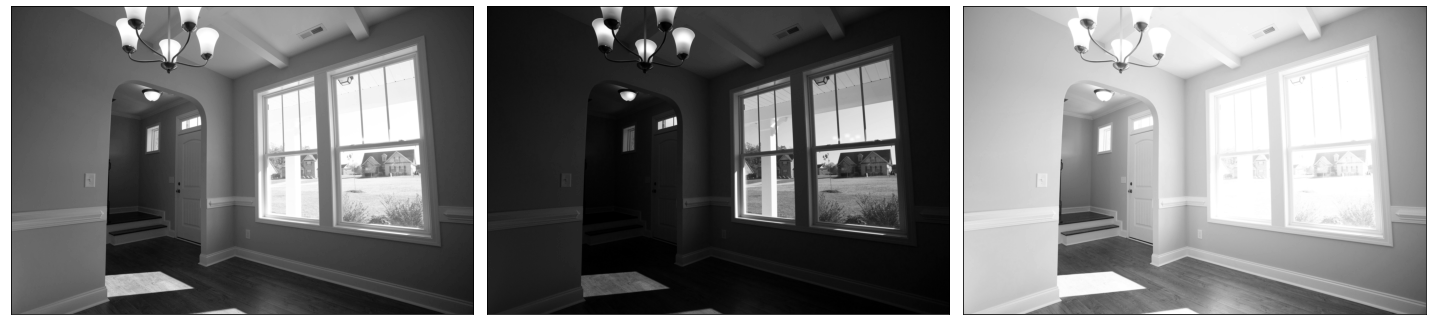

In [3]:
from plasma.conversion import rgb_to_luminance

# Convert to greyscale
luminance_a = rgb_to_luminance(image_ten_a)
luminance_b = rgb_to_luminance(image_ten_b)
luminance_c = rgb_to_luminance(image_ten_c)

# Plot
plt.figure(figsize=(20, 10))
plt.gray()
plt.subplot(1, 3, 1)
plt.imshow(to_greyscale(luminance_a.squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(to_greyscale(luminance_b.squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(to_greyscale(luminance_c.squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

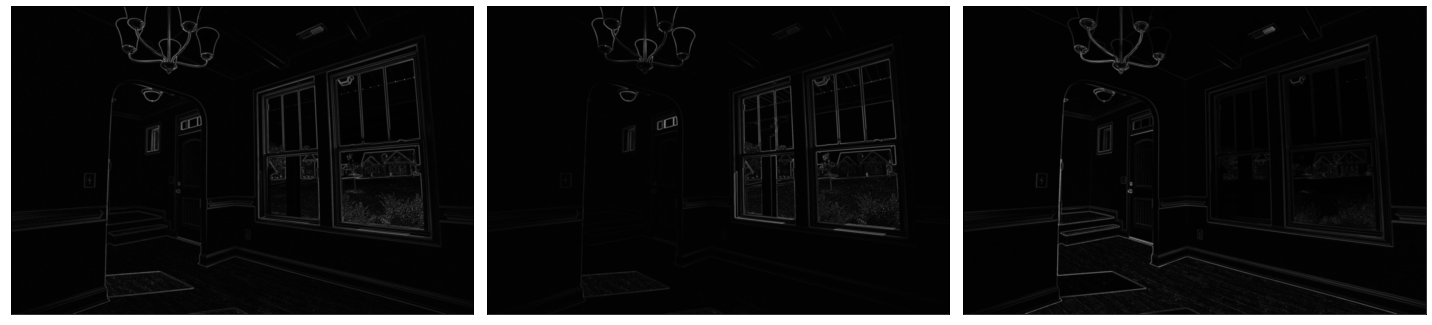

In [4]:
from plasma.filters import laplacian_of_gaussian_filter

# Compute constrast weights
contrast_a = laplacian_of_gaussian_filter(luminance_a)
contrast_b = laplacian_of_gaussian_filter(luminance_b)
contrast_c = laplacian_of_gaussian_filter(luminance_c)

# Plot
plt.figure(figsize=(20, 10))
plt.gray()
plt.subplot(1, 3, 1)
plt.imshow(to_map(contrast_a.squeeze(dim=0) / contrast_a.max()))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(to_map(contrast_b.squeeze(dim=0) / contrast_b.max()))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(to_map(contrast_c.squeeze(dim=0) / contrast_c.max()))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

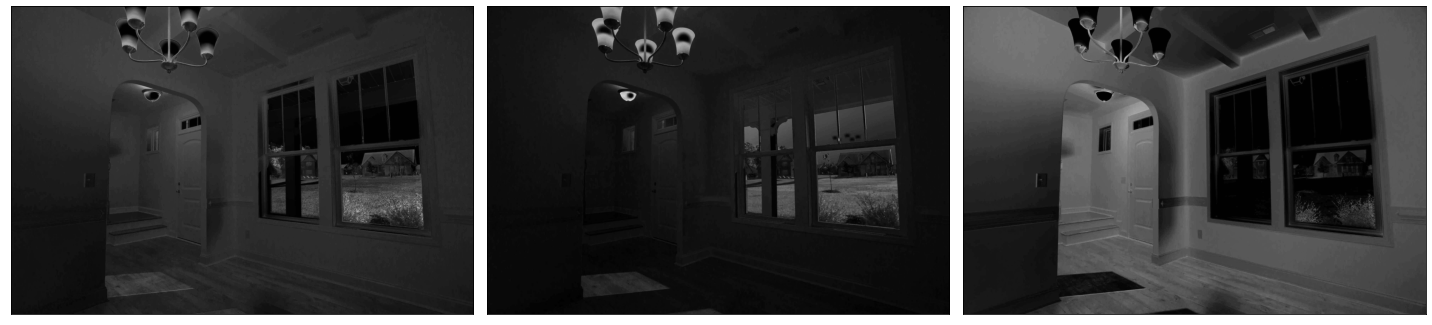

In [5]:
# Compute saturation weights
saturation_a = image_ten_a.std(dim=1, keepdim=True)
saturation_b = image_ten_b.std(dim=1, keepdim=True)
saturation_c = image_ten_c.std(dim=1, keepdim=True)

# Plot
plt.figure(figsize=(20, 10))
plt.gray()
plt.subplot(1, 3, 1)
plt.imshow(to_map(saturation_a.squeeze(dim=0) / saturation_a.max()))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(to_map(saturation_b.squeeze(dim=0) / saturation_b.max()))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(to_map(saturation_c.squeeze(dim=0) / saturation_c.max()))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

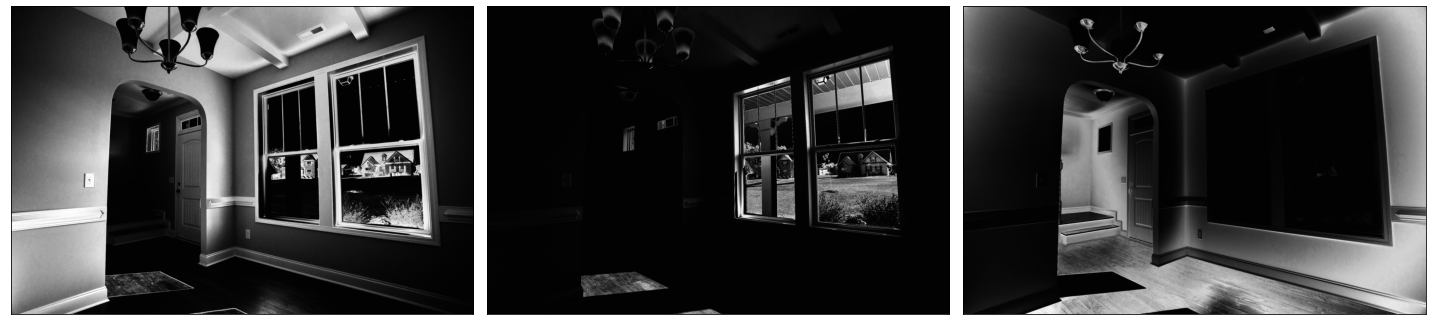

In [6]:
# Compute exposure weights
alpha = 0.0
sigma = 0.4
exposure_a = (-(image_ten_a - alpha).pow(2.) / (2 * sigma ** 2)).exp().prod(dim=1, keepdim=True)
exposure_b = (-(image_ten_b - alpha).pow(2.) / (2 * sigma ** 2)).exp().prod(dim=1, keepdim=True)
exposure_c = (-(image_ten_c - alpha).pow(2.) / (2 * sigma ** 2)).exp().prod(dim=1, keepdim=True)

# Plot
plt.figure(figsize=(20, 10))
plt.gray()
plt.subplot(1, 3, 1)
plt.imshow(to_map(exposure_a.squeeze(dim=0) / exposure_a.max()))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(to_map(exposure_b.squeeze(dim=0) / exposure_b.max()))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(to_map(exposure_c.squeeze(dim=0) / exposure_c.max()))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

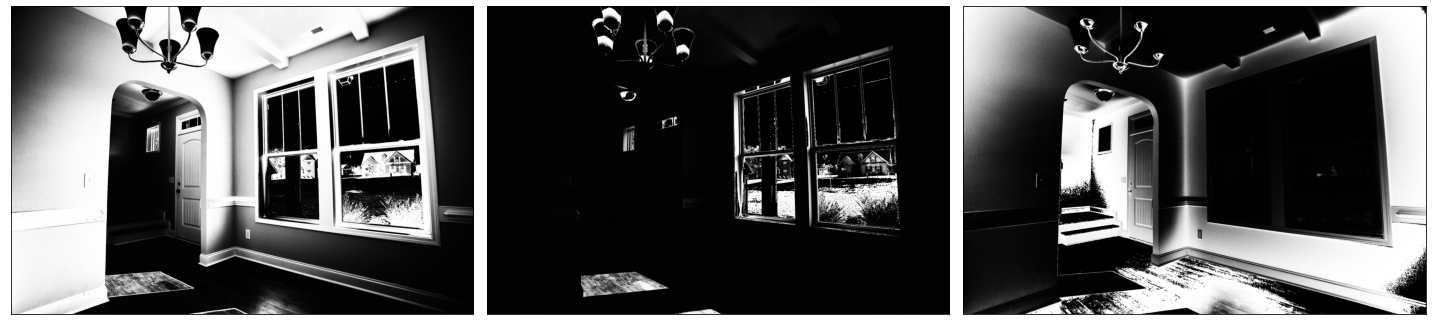

In [24]:
from torch import cat
from torch.nn.functional import normalize

# Compute weight maps
omega_con = 0.
omega_exp = 1.
omega_sat = 1.
weight_a = cat([ contrast_a.pow(omega_con), exposure_a.pow(omega_exp), saturation_a.pow(omega_sat) ], dim=1).prod(dim=1, keepdim=True)
weight_b = cat([ contrast_b.pow(omega_con), exposure_b.pow(omega_exp), saturation_b.pow(omega_sat) ], dim=1).prod(dim=1, keepdim=True)
weight_c = cat([ contrast_c.pow(omega_con), exposure_c.pow(omega_exp), saturation_c.pow(omega_sat) ], dim=1).prod(dim=1, keepdim=True)

# Normalize
weights = cat([ weight_a, weight_b, weight_c ], dim=1)
weights = normalize(weights, p=1, dim=1, eps=1e-8)
weight_a, weight_b, weight_c = weights.split(1, dim=1)

# Plot
plt.figure(figsize=(20, 10))
plt.gray()
plt.subplot(1, 3, 1)
plt.imshow(to_map(weight_a.squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(to_map(weight_b.squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(to_map(weight_c.squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

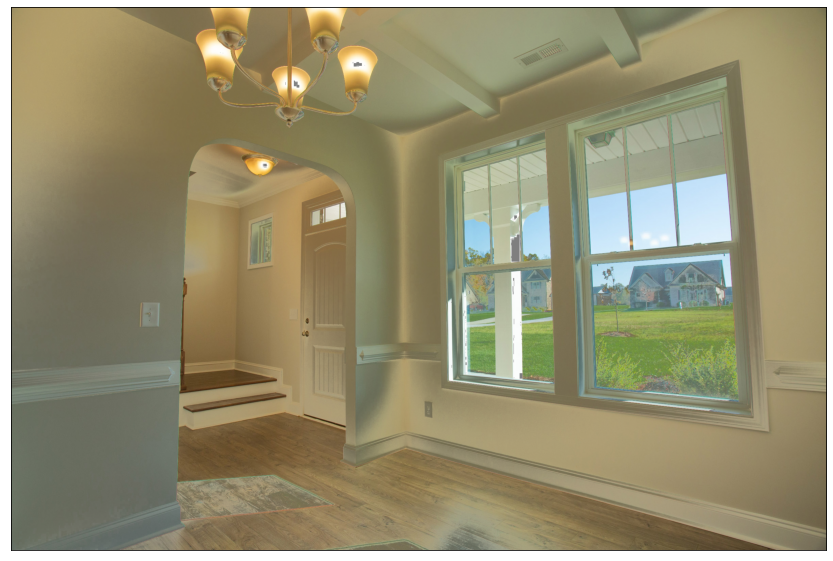

In [25]:
# Compute fusion
fusion = image_ten_a * weight_a + image_ten_b * weight_b + image_ten_c * weight_c

# Plot
plt.figure(figsize=(20, 10))
plt.imshow(to_image(fusion.squeeze(dim=0)))
plt.xticks([])
plt.yticks([])
plt.show()